In [45]:
#IMPORTING THE LIBRARIES
import random as rd
import numpy as np 
import matplotlib.pyplot as plt 
import statistics as stat
import math
from scipy import optimize
from math import *
import pandas as pd
from scipy import integrate as intg
import warnings
np.seterr(divide='ignore', invalid='ignore')
import scipy.integrate as integrate
from tqdm import tqdm
import cmath
import scipy
warnings.filterwarnings('ignore')
from utils import *

## Estimation

In [47]:
VIX = pd.read_csv('data/VIX_jfqa.csv')
VIX = VIX.dropna(axis=1)
VIX.Date = pd.to_datetime(VIX['Date'], format='%Y%m%d') # .dt.strftime('%Y/%m/%d')
data = VIX.copy()
data.rename(columns={"Date":"DATE", "VIX_2": "VIX2M", "VIX_3": "VIX3M", "VIX_6": "VIX6M", "VIX_9": "VIX9M", "VIX_12": "VIX12M"}, inplace=True)
col = ['DATE','VIX','VIX2M','VIX3M','VIX6M','VIX9M','VIX12M']
data = data[col]
data = data[data.DATE>'2011']

In [12]:
#### step 1
def CostFunc_spotVol(spotVol, *args):
    '''
    mean of squared error for each date
    Given a subSample 'df' at a given date
    spotVol: spot volatility
    args: df, H, lamb,theta, without rho and nu
    '''
    df, H, lamb,theta = args
    alpha, rn= H+0.5, 2.5
    c, x = vec_c(20,rn,alpha), vec_x(20,rn,alpha)
    V0 = np.square(spotVol)
    ####################################################################
    t = 0 ## for VIX calculation
    tau = np.array([1.0/12, 2.0/12, 3.0/12, 6.0/12, 9.0/12, 12.0/12])
    VIX_ts = np.zeros_like(tau)
    for i in range(len(tau)):
        VIX2 = squared_VIX(t, c, x, V0, lamb,theta,nu,rho, tau[i])
        VIX_ts[i] = np.sqrt(VIX2)
    ####################################################################    
    err = np.mean(np.square(np.array(df.iloc[:,1:]) - VIX_ts)) 
    return err

#### step 2
def CostFunc_param_T(strucParams, *args):
    '''
    mean of squared error for whole period
    Given  'df' and spotVar for whole period
    strucParams: H, lamb,theta
    args: df, spotVar
    '''
    H, lamb,theta = strucParams
    alpha, rn= H+0.5, 2.5
    c, x = vec_c(20,rn,alpha), vec_x(20,rn,alpha)
    df, spotVar = args
    spotVarList1= spotVar.copy()
    spotVardict = {}
    dateList = np.unique(df.DATE)
    err = 0
    for i in range(len(dateList)):
        spotVardict[dateList[i]] = spotVarList1[i]

    for i in range(len(dateList)):
        date_i = dateList[i]
        V0 = spotVardict[date_i]
        tmp = df[df.DATE==date_i]
        ####################################################################
        t = 0 ## for VIX calculation
        tau = np.array([1.0/12, 2.0/12, 3.0/12, 6.0/12, 9.0/12, 12.0/12])
        VIX_ts = np.zeros_like(tau)
        for j in range(len(tau)):
            VIX2 = squared_VIX(t, c, x, V0, lamb,theta,nu,rho, tau[j])
            VIX_ts[j] = np.sqrt(VIX2)
        ####################################################################
        market_ts = np.array(tmp.iloc[:,1:])
        err += np.mean(np.square((market_ts - VIX_ts)))
    return err/len(dateList)

We make several effort to find suitable initial values before the formal estimation.

In [ ]:
%%time
dateList = np.unique(data.DATE)

H,n = 0.2, 20
alpha, rn= H+0.5, 2.5
c, x = vec_c(n,rn,alpha), vec_x(n,rn,alpha)

rho, nu = -0.7, 0.3
lamb,theta = 0.70, 0.06

nIter = 20
for iIter in tqdm(range(nIter)):
    iIter += 1
    ##############################################################
    #################     step 1       ###########################
    ##############################################################
    strucParams0 = np.array([H, lamb,theta])
    spotVol = np.zeros(len(dateList)) # spot volatility
    
    for j in range(len(dateList)):
        df = data[data.DATE==dateList[j]]
        args = tuple([df, H, lamb,theta])
        curr_IVol = df.iloc[0,1]/100
        paramRanges = (slice(0.01,0.99,0.0001),) # brute force for spot volatility
        res = optimize.brute(CostFunc_spotVol,paramRanges,args=args,
                       full_output=True, finish=None)
        spotVol[j] = res[0]
    print('Step 1 finished!')

    ##############################################################
    #################     step 2       ###########################
    ##############################################################    
    df = data[data.DATE.isin(dateList)].copy()
    x0 = strucParams0
    spotVar = spotVol**2
    args = tuple([df, spotVar])
    bounds = ((0.03,0.39),  (0.01, 9.99),(0.01, 0.19)) # constraints from economic priors of the model parameters

    res = optimize.minimize(CostFunc_param_T, x0, args, method='Nelder-Mead',options={"maxiter":1000, 'disp': True},
                            bounds=bounds, tol=1e-8)
    res = optimize.minimize(CostFunc_param_T, np.round(res.x,4), args, method='SLSQP',
                            options={"maxfun":200, 'disp': True, 'finite_diff_rel_step': 0.001, 'ftol':1e-6}, jac=['3-point'],bounds=bounds)
    print('Step 2 optimal structural parameter：', np.round(res.x,4))
    print('Step 2 minimal objective   function: ', np.round(np.sqrt(res.fun/df.shape[0]),4))
    #### update structural parameter set
    H, lamb,theta = np.round(res.x, 4)
    print()

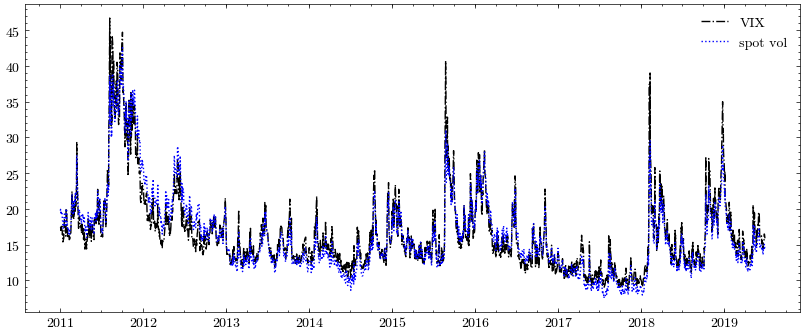

In [17]:
plt.figure(figsize=(10,4))

plt.plot(data['DATE'], data['VIX'],color='black',label='VIX',linestyle='dashdot')
plt.plot(data['DATE'], spotVol*100, color='blue', label='spot vol',linestyle='dotted')
plt.legend()

### Illustration of fitted values

100% 2136/2136 [00:13<00:00, 156.11it/s]


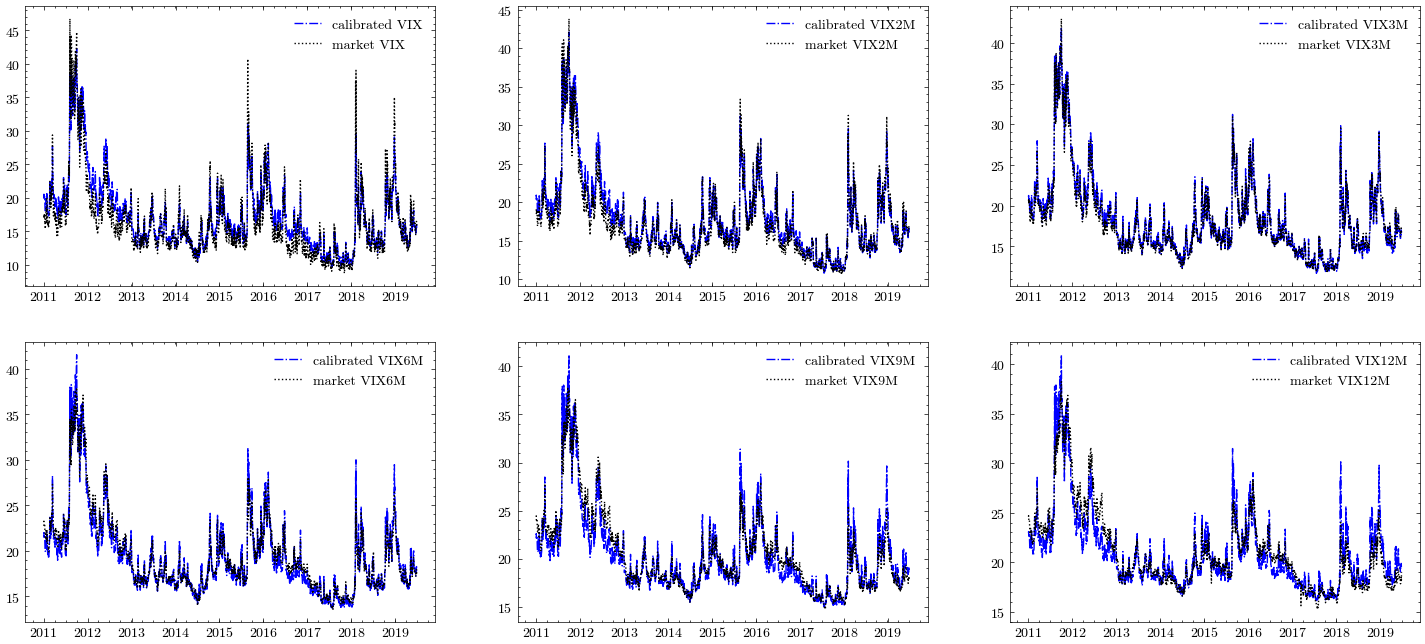

In [52]:
tau_ = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 12/12])

alpha, rn= H+0.5, 2.5
c, x = vec_c(20,rn,alpha), vec_x(20,rn,alpha)

VIX1M_calib,VIX2M_calib,VIX3M_calib,VIX6M_calib,VIX9M_calib,VIX12M_calib = np.zeros(len(spotVol)), np.zeros(len(spotVol)), np.zeros(len(spotVol)),np.zeros(len(spotVol)), np.zeros(len(spotVol)), np.zeros(len(spotVol))
for i in tqdm(range(len(spotVol))):
    
    VIX1M_calib[i] = np.sqrt(squared_VIX(0, c, x, spotVol[i]**2,lamb,theta,nu,rho, tau_[0]))
    VIX2M_calib[i] = np.sqrt(squared_VIX(0, c, x, spotVol[i]**2,lamb,theta,nu,rho, tau_[1]))
    VIX3M_calib[i] = np.sqrt(squared_VIX(0, c, x, spotVol[i]**2,lamb,theta,nu,rho, tau_[2]))
    VIX6M_calib[i] = np.sqrt(squared_VIX(0, c, x, spotVol[i]**2,lamb,theta,nu,rho, tau_[3]))
    VIX9M_calib[i] = np.sqrt(squared_VIX(0, c, x, spotVol[i]**2,lamb,theta,nu,rho, tau_[4]))
    VIX12M_calib[i]= np.sqrt(squared_VIX(0, c, x, spotVol[i]**2,lamb,theta,nu,rho, tau_[5]))

plt.figure(figsize=(18,8))
plt.subplot(231)
plt.plot(data['DATE'], VIX1M_calib,  color='blue',  label='calibrated VIX', linestyle='dashdot')
plt.plot(data['DATE'], data['VIX'],color='black',label='market VIX',linestyle='dotted')
plt.legend()
plt.subplot(232)
plt.plot(data['DATE'], VIX2M_calib,  color='blue',  label='calibrated VIX2M', linestyle='dashdot')
plt.plot(data['DATE'], data['VIX2M'],color='black',label='market VIX2M',linestyle='dotted')
plt.legend()
plt.subplot(233)
plt.plot(data['DATE'], VIX3M_calib,  color='blue',  label='calibrated VIX3M', linestyle='dashdot')
plt.plot(data['DATE'], data['VIX3M'],color='black',label='market VIX3M',linestyle='dotted')
plt.legend()
plt.subplot(234)
plt.plot(data['DATE'], VIX6M_calib,  color='blue',  label='calibrated VIX6M', linestyle='dashdot')
plt.plot(data['DATE'], data['VIX6M'],color='black',label='market VIX6M',linestyle='dotted')
plt.legend()

plt.subplot(235)
plt.plot(data['DATE'], VIX9M_calib,  color='blue',  label='calibrated VIX9M', linestyle='dashdot')
plt.plot(data['DATE'], data['VIX9M'],color='black',label='market VIX9M',linestyle='dotted')
plt.legend()

plt.subplot(236)
plt.plot(data['DATE'], VIX12M_calib,  color='blue',  label='calibrated VIX12M', linestyle='dashdot')
plt.plot(data['DATE'], data['VIX12M'],color='black',label='market VIX12M',linestyle='dotted')
plt.legend()
# plt.xticks(data.DATE[::500])
# plt.savefig('results/VIX_calibrate_lheston_2011.eps',dpi=400)